In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pylab as plt
import yfinance as yf
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

In [6]:
ticker=["GOOG"]

# Fetch historical data for the ticker
data = yf.download(ticker, start='2007-07-22', end='2012-03-28',interval="1d")

# Select the 'Adj Close' price for the test
close_prices = data['Adj Close'].dropna()

# Perform the ADF test
adf_result = ts.adfuller(close_prices,1)

# Print the ADF test results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

[*********************100%%**********************]  1 of 1 completed
ADF Statistic: -1.7033050166796766
p-value: 0.42941044240455095
Critical Values:
   1%: -3.435903883450231
   5%: -2.863992471942117
   10%: -2.5680757461936223


In [7]:
goog = yf.download(ticker, start='2000-01-01', end='2024-01-01')

def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts

    Parameters
    ----------
    ts : `numpy.array`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the poly fit output
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# Create a Gometric Brownian Motion, Mean-Reverting and Trending Series
gbm = np.log(np.cumsum(np.random.randn(100000))+1000)
mr = np.log(np.random.randn(100000)+1000)
tr = np.log(np.cumsum(np.random.randn(100000)+1)+1000)

# Output the Hurst Exponent for each of the above series
# and the price of ticker (the Adjusted Close price) for 
# the ADF test given above in the article
print("Hurst(GBM):   %s" % hurst(gbm))
print("Hurst(MR):    %s" % hurst(mr))
print("Hurst(TR):    %s" % hurst(tr))

# Assuming you have run the above code to obtain 'goog'!
print("Hurst(Ticker):  %s" % hurst(goog['Adj Close'].values))

[*********************100%%**********************]  1 of 1 completed
Hurst(GBM):   0.4998139429232393
Hurst(MR):    -0.00021068180305315658
Hurst(TR):    0.9562128740795021
Hurst(Ticker):  0.4699429607169498


In [8]:
def calculate_half_life(series):
    # Calculate the lagged series
    series_lag = series.shift(1)
    
    # Calculate the change in the series
    delta_series = series - series_lag
    
    # Remove missing values
    series_lag = series_lag[1:]
    delta_series = delta_series[1:]
    
    # Add a constant term to the lagged series
    series_lag_constant = sm.add_constant(series_lag)
    
    # Fit the AR(1) model
    model = sm.OLS(delta_series, series_lag_constant)
    results = model.fit()
    
    # Get the AR(1) coefficient
    theta = results.params.iloc[1]  # Use iloc to avoid the warning
    
    # Calculate the half-life
    half_life = -np.log(2) / theta
    
    return half_life

# Calculate half-life
halflife = calculate_half_life(close_prices)
print("Half-Life of Mean Reversion:", halflife)

Half-Life of Mean Reversion: 123.85666533807606


In [9]:
def calculate_half_life(series):
    # Calculate the lagged series
    series_lag = series.shift(1)
    
    # Calculate the change in the series
    delta_series = series - series_lag
    
    # Remove missing values
    series_lag = series_lag[1:]
    delta_series = delta_series[1:]
    
    # Add a constant term to the lagged series
    series_lag_constant = sm.add_constant(series_lag)
    
    # Fit the AR(1) model
    model = sm.OLS(delta_series, series_lag_constant)
    results = model.fit()
    
    # Get the AR(1) coefficient
    theta = results.params.iloc[1]  # Use iloc to avoid the warning
    
    # Calculate the half-life
    half_life = -np.log(2) / theta
    
    return half_life

# Calculate half-life
halflife = calculate_half_life(close_prices)
print("Half-Life of Mean Reversion:", halflife)

Half-Life of Mean Reversion: 123.85666533807606


<Axes: xlabel='Date'>

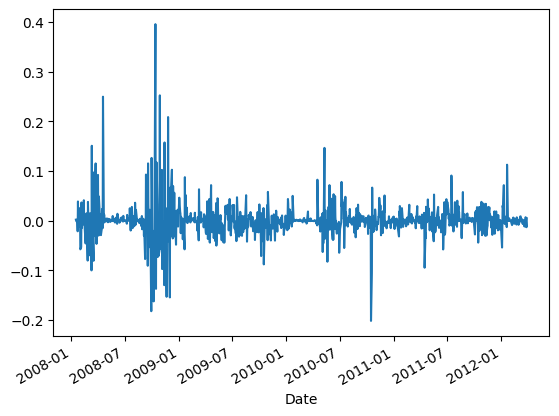

In [10]:
# Function to calculate the moving average
def moving_avg(close_prices, lookback):
    return close_prices.rolling(window=lookback).mean()

# Function to calculate the moving standard deviation
def moving_std(close_prices, lookback):
    return close_prices.rolling(window=lookback).std()

# Function to lag the series by 1 (shift by 1)
def lag(series, periods=1):
    return series.shift(periods)

# Assuming 'y' is a pandas Series and 'halflife' is defined
lookback = round(halflife)  # Setting lookback to halflife

# Calculate market value
mktVal = -(close_prices - moving_avg(close_prices, lookback)) / moving_std(close_prices, lookback)

# Calculate PnL
pnl = lag(mktVal, 1) * (close_prices - lag(close_prices, 1)) / lag(close_prices, 1)
pnl.dropna().plot()
